In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def mse(true, pred):
    return np.mean((pred - true) ** 2)

def mse_derivative(true, pred):
    return 2 * (pred - true) / true.size

In [4]:
def standarize(data, train_mean, std):
    return (data - train_mean) / std

In [5]:
class MLP:
    def __init__(self, input_dimension, hidden_dimension, output_dimension, learning_rate):
        self.learning_rate = learning_rate

        self.weight_input_hidden = np.random.randn(input_dimension, hidden_dimension) * 0.01
        self.weight_hidden_output = np.random.randn(hidden_dimension, output_dimension) * 0.01

        self.bias_hidden = np.zeros((1, hidden_dimension))
        self.bias_output = np.zeros((1, output_dimension))

    def forward_propagation(self, x):
        self.x = x
        self.hidden_layer_input = np.dot(x, self.weight_input_hidden) + self.bias_hidden
        self.hidden_layer_output = relu(self.hidden_layer_input)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weight_hidden_output) + self.bias_output
        self.output = self.output_layer_input
        return self.output
    
    def backward_propagation(self, y_true, y_pred):
        d_output_layer_input = mse_derivative(y_true, y_pred)

        d_weight_hidden_output = np.dot(self.hidden_layer_output.T, d_output_layer_input)
        d_bias_output = np.sum(d_output_layer_input, axis=0, keepdims=True)

        d_hidden_layer_output = np.dot(d_output_layer_input, self.weight_hidden_output.T)
        d_hidden_layer_input = d_hidden_layer_output * relu_derivative(self.hidden_layer_input)

        d_weight_input_hidden = np.dot(self.x.T, d_hidden_layer_input)
        d_bias_hidden = np.sum(d_hidden_layer_input, axis=0, keepdims=True)

        self.weight_input_hidden -= self.learning_rate * d_weight_input_hidden
        self.weight_hidden_output -= self.learning_rate * d_weight_hidden_output
        self.bias_hidden -= self.learning_rate * d_bias_hidden
        self.bias_output -= self.learning_rate * d_bias_output

    def train(self, x, y, epochs):
        loss_list = []
        for epoch in range(epochs):
            y_pred = self.forward_propagation(x)
            loss = mse(y, y_pred)
            loss_list.append(loss)
            self.backward_propagation(y, y_pred)     
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss}")
        return loss_list, y_pred
    
    def evaluate(self, x, y):
        y_pred = self.forward_propagation(x)
        loss = mse(x, y)
        return loss, y_pred

In [ ]:
file_path = '../../Datasets/조업편차분석.csv'
data = pd.read_csv(file_path)

data['Origin'] = data.index
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = int(len(shuffled_data) * 0.8)
train_data, test_data = shuffled_data.iloc[:train_size], shuffled_data.iloc[train_size:]

In [ ]:
x_train, y_train = train_data.drop(columns=['No.', 'A1', 'Origin'], axis=1), train_data['A1']

x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
y_train_mean = np.mean(y_train, axis=0)
y_train_std = np.std(y_train, axis=0)

x_train = standarize(x_train, x_train_mean, x_train_std).to_numpy()
y_train = standarize(y_train, y_train_mean, y_train_std).to_numpy().reshape(-1, 1)

In [ ]:
np.random.seed(42)

input_dimension = x_train.shape[1]
hidden_dimension = 64
output_dimension = y_train.shape[1]

mlp_model = MLP(
    input_dimension=input_dimension, 
    hidden_dimension=hidden_dimension, 
    output_dimension=output_dimension, 
    learning_rate=0.001)
loss_list, y_pred_train = mlp_model.train(x_train, y_train, epochs=1000)

plt.figure(figsize=(10, 6))
plt.plot(loss_list)
plt.show()

In [10]:
loss_list, y_pred_train = mlp_model.train(x_train, y_train, epochs=1000)

Epoch 100, Loss: 0.9867059281723791
Epoch 200, Loss: 0.9642027016354502
Epoch 300, Loss: 0.9171161406316524
Epoch 400, Loss: 0.8182717835798207
Epoch 500, Loss: 0.6418098655151057
Epoch 600, Loss: 0.41565072698231104
Epoch 700, Loss: 0.2352479603691824
Epoch 800, Loss: 0.14199988488300697
Epoch 900, Loss: 0.0997629049535532
Epoch 1000, Loss: 0.07724910286907237


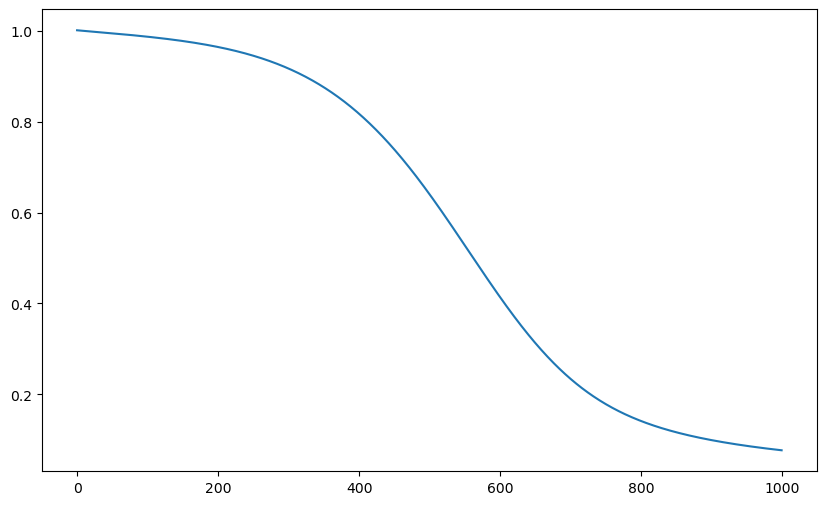

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(loss_list)
plt.show()

In [ ]:
test_data_sorted = test_data.sort_values(by='Origin').reset_index(drop=True)

x_test_sorted, y_test_sorted = test_data_sorted.drop(columns=['No.', 'A1', 'Origin'], axis=1), test_data_sorted['A1']
x_test_sorted = standarize(x_test_sorted, x_train_mean, x_train_std).to_numpy()
y_test_sorted = standarize(y_test_sorted, y_train_mean, y_train_std).to_numpy().reshape(-1, 1)

_, y_test_pred = mlp_model.evaluate(x_test_sorted, y_test_sorted)

plt.figure(figsize=(50, 6))
plt.plot(y_test_sorted, marker="o")
plt.plot(y_test_pred, marker="x")
plt.show()

1.786991531284931


In [14]:
def evaluate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse_value = mse(y_true, y_pred)
    rmse = np.sqrt(mse_value)
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r_square = 1 - (ss_residual / ss_total)
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse_value:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-square: {r_square:.4f}")

evaluate_metrics(y_test_sorted, y_test_pred)

MAE: 0.2066
MSE: 0.0813
RMSE: 0.2852
R-square: 0.9273


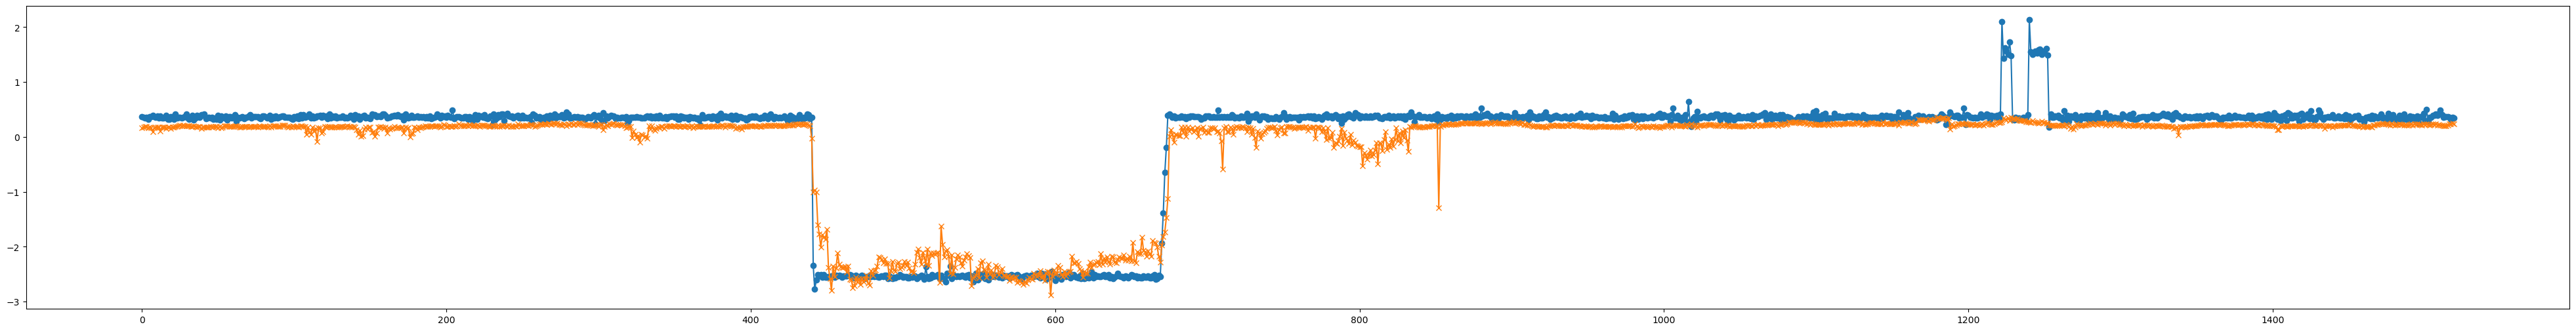